## Librerias

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation
from keras.optimizers import RMSprop, Adam
import math
from matplotlib import pyplot as plt
import numpy as np

## Modelo para resolver la ecuación diferencial 

#### $$y^{''} + y = 0$$ con las condiciones $$y(0)= 1$$ y $$y(\frac{\pi}{3})=-\frac{1}{2}$$ 

In [37]:
pi = tf.constant(math.pi)
class ODEsolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
         batch_size = tf.shape(data)[0]
         min = tf.cast(tf.reduce_min(data),tf.float32)
         max = tf.cast(tf.reduce_max(data),tf.float32)
         x = tf.random.uniform((batch_size,1), minval=min, maxval=max)

         with tf.GradientTape() as tape:
             with tf.GradientTape() as tape2:
                 tape2.watch(x)
                 y_pred = self(x, training=True)
                 with tf.GradientTape() as tape3:
                    tape3.watch(x)
                    y_pred = self(x, training=True)
                    dy = tape3.gradient(y_pred,x)
             ddy = tape2.gradient(dy, x)#segunda derivada del modelo con respecto a entradas x
             x1_o = tf.zeros((batch_size,1)) #valor de x en condicion inicial x1_0=0
             x2_o = tf.ones((batch_size,1))*math.pi/3. #valor de x en condicion inicial x2_0=pi/3
             y1_o = self(x1_o,training=True) #valor del modelo en en x1_0
             y2_o = self(x2_o,training=True) #valor del modelo en en x2_0
             eq = ddy + y_pred #Ecuacion diferencial evaluada en el modelo. Queremos que sea muy pequeño
             ic1 = 1. #valor que queremos para la condicion inicial o el modelo en x_0
             ic2 = -0.5
             loss = self.mse(0., eq) + self.mse(y1_o,ic1) + self.mse(y2_o,ic2)

        # Apply grads
         grads = tape.gradient(loss, self.trainable_variables)
         self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        #update metrics
         self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
         return {"loss": self.loss_tracker.result()}

# Creación del modelo

In [43]:
model = ODEsolver()
model.add(Dense(100, activation='tanh', input_shape=(1,)))
model.add(Dense(300, activation='tanh'))
model.add(Dense(150, activation='tanh'))
model.add(Dense(1, activation='tanh'))
model.add(Dense(1))


model.summary()

Model: "od_esolver_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 100)               200       
                                                                 
 dense_22 (Dense)            (None, 300)               30300     
                                                                 
 dense_23 (Dense)            (None, 150)               45150     
                                                                 
 dense_24 (Dense)            (None, 1)                 151       
                                                                 
 dense_25 (Dense)            (None, 1)                 2         
                                                                 
Total params: 75,803
Trainable params: 75,803
Non-trainable params: 0
_________________________________________________________________


# Graficando

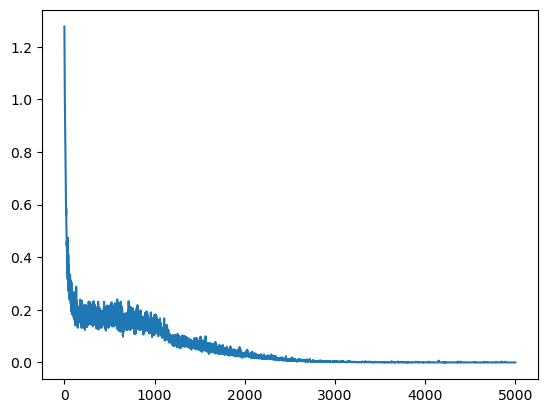

In [44]:
model.compile(Adam(learning_rate=0.0001),metrics=['loss'])
x=tf.linspace(-5,5,100)
history = model.fit(x,epochs=5000,verbose=0)
plt.plot(history.history["loss"])

4/4 [==============================] - 0s 7ms/step


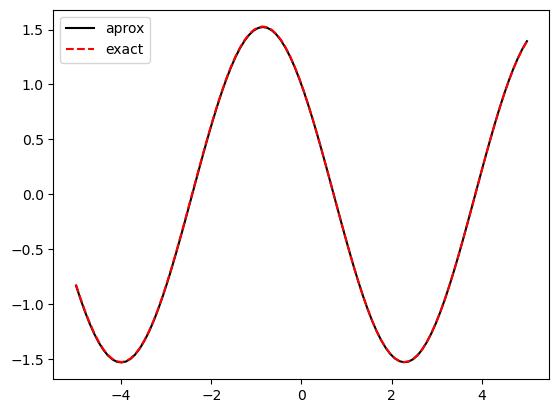

In [48]:
x_testv = tf.linspace(-5,5,100)
a=model.predict(x_testv)
plt.plot(x_testv,a,label="aprox", color='black')
plt.plot(x_testv, tf.math.cos(x) - (2.*math.sqrt(3.)/3.)*tf.math.sin(x),label="exact", color='red', linestyle='--')
plt.legend()
plt.show()